# Word2Vec with NLTK Reuters Corpus and Visualization using t-SNE

## Lab Activity

### Import Required Libraries

In [4]:
import nltk
from nltk.corpus import reuters, stopwords
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

Download the Reuters corpus (if not already downloaded)

In [5]:
nltk.download('reuters')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/ahmedyousef/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ahmedyousef/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ahmedyousef/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ahmedyousef/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Step 1: Load the Reuters Corpus
Extract sentences from the Reuters corpus Explanation: The Reuters corpus contains a collection of financial news articles. Each sentence will be tokenized into words to create the vocabulary for Word2Vec.

In [6]:
corpus_sentences = []
for fileid in reuters.fileids():
    raw_text = reuters.raw(fileid)
    tokenized_sentence = [word for word in nltk.word_tokenize(raw_text) if word.isalnum() and word.lower() not in stopwords.words('english')]
    corpus_sentences.append(tokenized_sentence)
print(f"Number of sentences in the Reuters corpus: {len(corpus_sentences)}")

Number of sentences in the Reuters corpus: 10788


### Step 2: Train a Word2Vec Model
Explanation: Word2Vec will learn vector representations for each word in the vocabulary.

Parameters:
- vector_size: Size of the word embedding vectors.
- window: Context window size for training.
- min_count: Minimum frequency for a word to be included in the vocabulary.
- workers: Number of threads for parallel processing.

In [7]:
model = Word2Vec(sentences=corpus_sentences, vector_size=100, window=5, min_count=5, workers=4)
# Print vocabulary size
print(f"Vocabulary size: {len(model.wv.index_to_key)}")

Vocabulary size: 12662


### Step 3: Extract Word Embeddings for Visualization

In [8]:
import numpy as np
# Extract the learned word vectors and their corresponding words for visualization.
words = list(model.wv.index_to_key)[:200] # Limit to top 200 words for better visualization
word_vectors = np.array([model.wv[word] for word in words])

### Step 4: Reduce Dimensionality with t-SNE

In [9]:
# Use t-SNE to project the high-dimensional word embeddings into a 2D space.
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
word_vectors_2d = tsne.fit_transform(word_vectors)

### Step 5: Visualize the Word Embeddings

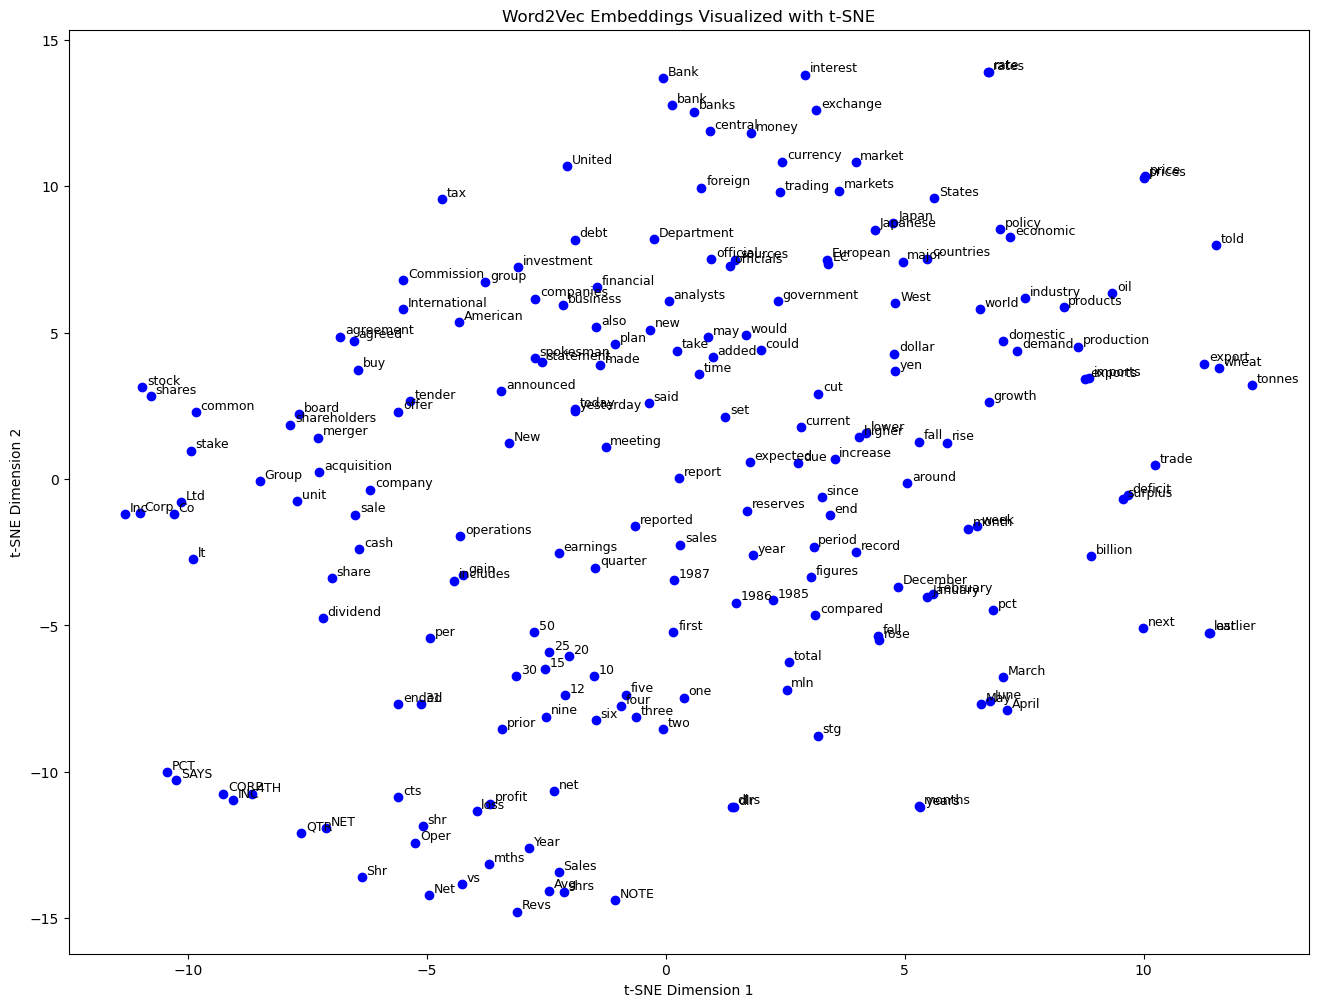

In [10]:
# Plot the 2D t-SNE visualization of the word embeddings with their labels.
def plot_embeddings(vectors, labels):
    plt.figure(figsize=(16, 12))
    for i, label in enumerate(labels):
        x, y = vectors[i]
        plt.scatter(x, y, color='blue')
        plt.text(x + 0.1, y + 0.1, label, fontsize=9)
    plt.title("Word2Vec Embeddings Visualized with t-SNE")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()
plot_embeddings(word_vectors_2d, words)

### Key Questions for Students:

**What do you observe about the clusters in the t-SNE plot?**

The plot looks like it is clustering words that are similar together. For instance, the words (year, mths (months), hrs (hours)) are very close together. 

**How do you think the choice of parameters (e.g., window size, vector size) affects the embeddings?**

Window Size: For larger window size it captures global semantic relationships, but smaller window size focuses on the immediate neighbors of a word (local context).

Vector Size: This is the number of numbers used to describe each word. A larger vector can capture more details about a word’s meaning but needs more data and processing. A smaller vector is simpler but might miss some of those details.

**What are the limitations of using Word2Vec and t-SNE for NLP tasks?**

Limitations of Word2Vec:

Single Meaning: It gives one representation per word, even if the word has several meanings (like “bank” meaning a riverbank or a financial institution).
Data Hungry: It needs a lot of text to learn good word meanings.
Rare Words: It struggles with words that don’t appear often.

Limitations of t-SNE:

Speed: It can be slow when there are a lot of words.
Local Focus: It does a great job showing small groups of similar words, but it might not show the overall big picture very clearly.


## Information Retreival Task:
Task: Build a Document Retrieval System using Word2Vec
1. Given a query string, �nd the most relevant documents from the Reuters corpus using
Word2Vec embeddings.
2. Steps:
a. Preprocess the query string by tokenizing and removing stop words.
b. Compute the average Word2Vec embedding for the query string.
c. Compute the average Word2Vec embedding for each document in the Reuters corpus.
d. Use cosine similarity to �nd the top N most relevant documents for the query.
3. Display the top N document IDs and their similarity scores.


### The functions

In [11]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Tokenizes the input text, filters out non-alphanumeric tokens,
    and removes English stop words.
    """
    tokens = nltk.word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]
    return tokens

def compute_avg_embedding(tokens, model):
    """
    Computes the average Word2Vec embedding for a list of tokens.
    If none of the tokens exist in the model's vocabulary,
    returns a zero vector.
    """
    # Get embeddings for tokens present in the model vocabulary
    vecs = [model.wv[word] for word in tokens if word in model.wv]
    if not vecs:  # If the list is empty, return a zero vector
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)

def retrieve_documents(query, model, doc_embeddings, top_n=5):
    """
    Given a query string, computes its average embedding and compares it
    with precomputed document embeddings using cosine similarity.
    Returns the top_n document IDs along with their similarity scores.
    """
    # Preprocess the query and compute its average embedding
    query_tokens = preprocess_text(query)
    query_vec = compute_avg_embedding(query_tokens, model)
    
    # Compute cosine similarity between the query and each document
    similarities = {}
    for doc_id, doc_vec in doc_embeddings.items():
        # Handle cases where either vector is zero to avoid division by zero
        if np.linalg.norm(query_vec) == 0 or np.linalg.norm(doc_vec) == 0:
            sim = 0
        else:
            sim = np.dot(query_vec, doc_vec) / (np.linalg.norm(query_vec) * np.linalg.norm(doc_vec))
        similarities[doc_id] = sim
    
    # Sort documents by similarity in descending order
    sorted_docs = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_docs[:top_n]

### Compute embeddings

In [12]:
# Precompute document embeddings for all Reuters documents
doc_embeddings = {}
doc_ids = reuters.fileids()

# Loop through each document in the Reuters corpus
for doc_id in doc_ids:
    raw_text = reuters.raw(doc_id)
    tokens = preprocess_text(raw_text)
    avg_embedding = compute_avg_embedding(tokens, model)
    doc_embeddings[doc_id] = avg_embedding


### Testing it

In [15]:
query = "oil prices and stock market"
top_docs = retrieve_documents(query, model, doc_embeddings, top_n=5)

print("Top relevant documents for the query:")
for doc_id, score in top_docs:
    print(f"Document ID: {doc_id}, Similarity Score: {score:.4f}")

print(reuters.raw(top_docs[0][0]))

Top relevant documents for the query:
Document ID: training/11723, Similarity Score: 0.8848
Document ID: test/15607, Similarity Score: 0.8762
Document ID: training/834, Similarity Score: 0.8696
Document ID: training/3181, Similarity Score: 0.8662
Document ID: training/2998, Similarity Score: 0.8662
OIL PRICES SAID NOW BASED ON FUTURES PRICE
  Energy futures now set the
  standard for oil pricing, said Arnold Safer, president of The
  Energy Futures Group Inc, a consulting firm.
       "Petroleum futures trading at the New York Mercantile
  Exchange literally set spot market prices in the U.S.," he
  said, adding that some oil products sellers now offer contracts
  based on a daily average of NYMEX prices.
       He also said that petroleum futures are a major market for
  oil companies as well as for commodity traders. His remarks
  were made at the National Petroleum Refiners Association.
  


